# 1: Imports and Configuration

In [1]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

NUM_ENSEMBLE_MODELS = 20
INPUT_DIM = 3
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_LSTM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 32
MODEL_SAVE_DIR = "ensemble_models_pytorch"
DATA_FILE = 'synthetic_ehr_data.csv'

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# 2: Device Setup (GPU/CPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 3: Load Data

In [3]:
print(f"Loading data from {DATA_FILE}...")
try:
    df = pd.read_csv(DATA_FILE)
    print("Data loaded successfully.")
    print(df.head())
    print(f"\nTotal records: {len(df)}")
    print(f"Unique patients: {df['patient_id'].nunique()}")
except FileNotFoundError:
    print(f"Error: {DATA_FILE} not found. Make sure it's in the same directory.")
    raise

Loading data from synthetic_ehr_data.csv...
Data loaded successfully.
   patient_id  time_step  feature_A  feature_B  feature_C  outcome
0           0          0  44.497655  19.202417          5        0
1           0          1  55.154331  20.111109          1        0
2           0          2  54.738608  17.861035          2        0
3           0          3  63.684501  17.340913          4        0
4           0          4  40.831732  19.412622          1        0

Total records: 20219
Unique patients: 2000


# 4: Preprocess Data into Sequences

In [4]:
print("Preprocessing data into sequences...")
grouped_data = df.groupby('patient_id')
patient_sequences = []
patient_labels = []
feature_cols = ['feature_A', 'feature_B', 'feature_C']

for patient_id, group in grouped_data:
    group = group.sort_values('time_step')
    step_tensors = [torch.tensor(row[feature_cols].values, dtype=torch.float32) for index, row in group.iterrows()]

    if step_tensors:
        patient_sequence_tensor = torch.stack(step_tensors)
        patient_sequences.append(patient_sequence_tensor)
        label = group['outcome'].iloc[0]
        patient_labels.append(torch.tensor([label], dtype=torch.float32))
    else:
         print(f"Warning: Patient {patient_id} has no visit data. Skipping.")
         continue

print(f"Processed {len(patient_sequences)} patient sequences.")
if patient_sequences:
    print("Example sequence tensor shape (first patient):", patient_sequences[0].shape)
    print(f"Example label (first patient): {patient_labels[0].item()}")

Preprocessing data into sequences...
Processed 2000 patient sequences.
Example sequence tensor shape (first patient): torch.Size([11, 3])
Example label (first patient): 0.0


# 5: Define Custom Dataset

In [5]:
class EHRDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

print("EHRDataset class defined.")

EHRDataset class defined.


# 6: Define Collate Function

In [6]:
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, labels

print("collate_fn defined.")

collate_fn defined.


# 7: Create Dataset and DataLoader

In [7]:
ehr_dataset = EHRDataset(patient_sequences, patient_labels)
data_loader = DataLoader(ehr_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)

print(f"Dataset created with {len(ehr_dataset)} samples.")
print(f"DataLoader created with batch size {BATCH_SIZE}.")

# Optional: Check one batch shape
try:
    sample_batch, sample_lengths, sample_labels = next(iter(data_loader))
    print("\nSample batch sequences shape:", sample_batch.shape)
except StopIteration:
    print("\nWarning: DataLoader is empty.")

Dataset created with 2000 samples.
DataLoader created with batch size 32.

Sample batch sequences shape: torch.Size([32, 15, 3])


# 8: Define LSTM Model

In [8]:
class EhrLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(EhrLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.2 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # lengths must be on CPU for pack_padded_sequence
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input, (h0, c0))

        last_hidden_state = hn[-1]
        out = self.fc(last_hidden_state)
        return out

print("EhrLSTM model class defined.")

EhrLSTM model class defined.


# 9: Training Loop

In [9]:
training_times = []
print("\n--- Starting Ensemble Training ---")

for model_idx in range(NUM_ENSEMBLE_MODELS):
    print(f"\nTraining Model {model_idx + 1}/{NUM_ENSEMBLE_MODELS}")
    start_time = time.time()

    model = EhrLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LSTM_LAYERS).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model.train()

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        num_batches = 0
        for i, (sequences_batch, lengths_batch, labels_batch) in enumerate(data_loader):
            sequences_batch = sequences_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(sequences_batch, lengths_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0
        print(f"  Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}")

    model_save_path = os.path.join(MODEL_SAVE_DIR, f'pytorch_lstm_model_{model_idx}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"  Model {model_idx + 1} saved to {model_save_path}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)
    print(f"  Training time for Model {model_idx + 1}: {elapsed_time:.2f} seconds")

print("\n--- Ensemble Training Finished ---")


--- Starting Ensemble Training ---

Training Model 1/20
  Epoch [1/20], Loss: 0.5432
  Epoch [2/20], Loss: 0.5253
  Epoch [3/20], Loss: 0.5190
  Epoch [4/20], Loss: 0.5128
  Epoch [5/20], Loss: 0.5124
  Epoch [6/20], Loss: 0.5148
  Epoch [7/20], Loss: 0.5082
  Epoch [8/20], Loss: 0.5033
  Epoch [9/20], Loss: 0.5019
  Epoch [10/20], Loss: 0.5005
  Epoch [11/20], Loss: 0.5022
  Epoch [12/20], Loss: 0.5062
  Epoch [13/20], Loss: 0.4978
  Epoch [14/20], Loss: 0.5027
  Epoch [15/20], Loss: 0.5125
  Epoch [16/20], Loss: 0.5062
  Epoch [17/20], Loss: 0.5013
  Epoch [18/20], Loss: 0.5034
  Epoch [19/20], Loss: 0.4953
  Epoch [20/20], Loss: 0.5025
  Model 1 saved to ensemble_models_pytorch\pytorch_lstm_model_0.pth
  Training time for Model 1: 11.63 seconds

Training Model 2/20
  Epoch [1/20], Loss: 0.5531
  Epoch [2/20], Loss: 0.5343
  Epoch [3/20], Loss: 0.5227
  Epoch [4/20], Loss: 0.5198
  Epoch [5/20], Loss: 0.5143
  Epoch [6/20], Loss: 0.5222
  Epoch [7/20], Loss: 0.5104
  Epoch [8/20], L

# 10: Training Summary

In [10]:
total_training_time = np.sum(training_times)
average_training_time = np.mean(training_times)

print("\n--- Training Summary ---")
print(f"Total training time for {NUM_ENSEMBLE_MODELS} models: {total_training_time:.2f} seconds")
print(f"Average training time per model: {average_training_time:.2f} seconds")
print(f"Total estimated GPU/CPU time: {total_training_time/3600:.3f} hours") # Added calculation


--- Training Summary ---
Total training time for 20 models: 134.46 seconds
Average training time per model: 6.72 seconds
Total estimated GPU/CPU time: 0.037 hours


# --Evaluation--
# 11: Load Models and Generate Predictions

In [11]:
# === EVALUATION CELL 1: Load Models and Generate Predictions ===

import matplotlib.pyplot as plt # For plotting later
import numpy as np
import torch
import os
from torch.nn.functional import sigmoid # To convert logits to probabilities

# --- Load the Trained Ensemble Models ---
print("--- Loading Ensemble Models ---")
ensemble_models = []
# Ensure MODEL_SAVE_DIR and NUM_ENSEMBLE_MODELS are available from previous cells
for model_idx in range(NUM_ENSEMBLE_MODELS):
    model_path = os.path.join(MODEL_SAVE_DIR, f'pytorch_lstm_model_{model_idx}.pth')
    if os.path.exists(model_path):
        # Use variables defined earlier (INPUT_DIM, HIDDEN_DIM, etc.)
        model = EhrLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LSTM_LAYERS)
        state_dict = torch.load(model_path, map_location=device) # Load state dict
        model.load_state_dict(state_dict)                         # Apply state dict
        model.to(device)                                          # Move to device
        model.eval()                                              # Set to evaluation mode!
        ensemble_models.append(model)
        print(f" Loaded model {model_idx + 1} from {model_path}")
    else:
        print(f" WARNING: Model file not found at {model_path}. Check path and training.")

if not ensemble_models or len(ensemble_models) != NUM_ENSEMBLE_MODELS:
    print(f"\nError: Expected {NUM_ENSEMBLE_MODELS} models, but only loaded {len(ensemble_models)}. Stopping.")
    # Optional: raise Exception("Failed to load all ensemble models.")
else:
    print(f"\nSuccessfully loaded {len(ensemble_models)} models.")

    # --- Generate Predictions Using the Ensemble ---
    print("\n--- Generating Predictions ---")
    # Store predictions from each model and the true labels
    # all_predictions[m][p] = prediction from model m for patient p
    all_predictions = [[] for _ in range(len(ensemble_models))]
    all_labels = []

    # Ensure data_loader is available from a previous cell
    # No gradients needed for evaluation
    with torch.no_grad():
        for i, (sequences_batch, lengths_batch, labels_batch) in enumerate(data_loader):
            # Move data needed for model to device
            sequences_batch = sequences_batch.to(device)
            # Keep lengths on CPU as required by pack_padded_sequence
            # Keep labels on CPU for easier handling later

            # Store true labels for this batch
            all_labels.extend(labels_batch.numpy().flatten())

            # Get predictions from EACH model in the ensemble
            for model_idx, model in enumerate(ensemble_models):
                outputs = model(sequences_batch, lengths_batch)
                # Convert raw logits to probabilities using sigmoid
                probabilities = sigmoid(outputs).cpu().numpy().flatten()
                all_predictions[model_idx].extend(probabilities)

    # --- Verification ---
    # Convert lists to numpy arrays for easier handling later if desired
    all_labels = np.array(all_labels)
    all_predictions = [np.array(preds) for preds in all_predictions] # List of numpy arrays

    print("\nPrediction generation complete.")
    if len(all_labels) > 0:
        print(f" Total sequences evaluated: {len(all_labels)}")
        print(f" Shape of predictions from one model: {all_predictions[0].shape}")
        print(f" Shape of all labels: {all_labels.shape}")
        # Display example outputs for the first few sequences
        print("\nExample Predictions (Probabilities) for first 5 sequences:")
        for model_idx in range(len(ensemble_models)):
             print(f" Model {model_idx+1}: {np.round(all_predictions[model_idx][:5], 3)}")
        print(f"True Labels: {np.round(all_labels[:5], 3)}")
    else:
        print("Warning: No predictions were generated. Check DataLoader and model loading.")

    print("\nData structures `all_predictions` and `all_labels` are ready.")

# END OF EVALUATION CELL 1

--- Loading Ensemble Models ---
 Loaded model 1 from ensemble_models_pytorch\pytorch_lstm_model_0.pth
 Loaded model 2 from ensemble_models_pytorch\pytorch_lstm_model_1.pth
 Loaded model 3 from ensemble_models_pytorch\pytorch_lstm_model_2.pth
 Loaded model 4 from ensemble_models_pytorch\pytorch_lstm_model_3.pth
 Loaded model 5 from ensemble_models_pytorch\pytorch_lstm_model_4.pth
 Loaded model 6 from ensemble_models_pytorch\pytorch_lstm_model_5.pth
 Loaded model 7 from ensemble_models_pytorch\pytorch_lstm_model_6.pth
 Loaded model 8 from ensemble_models_pytorch\pytorch_lstm_model_7.pth
 Loaded model 9 from ensemble_models_pytorch\pytorch_lstm_model_8.pth
 Loaded model 10 from ensemble_models_pytorch\pytorch_lstm_model_9.pth
 Loaded model 11 from ensemble_models_pytorch\pytorch_lstm_model_10.pth
 Loaded model 12 from ensemble_models_pytorch\pytorch_lstm_model_11.pth
 Loaded model 13 from ensemble_models_pytorch\pytorch_lstm_model_12.pth
 Loaded model 14 from ensemble_models_pytorch\pytor

# 12a: Visualize Individual Patient Uncertainty

--- Visualizing Uncertainty for Selected Patients (Zoomed, 15 Bins) ---
Plots will be saved in: patient_histograms
Generating histograms based on 20 models.
Saved plot to patient_histograms\patient_0_histogram.png


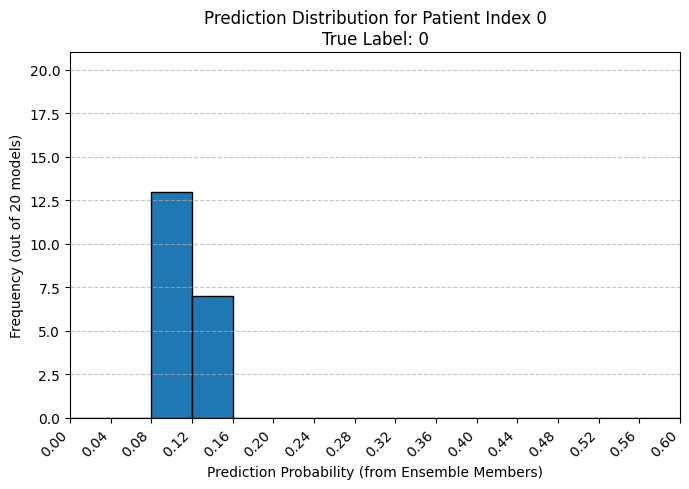

Saved plot to patient_histograms\patient_4_histogram.png


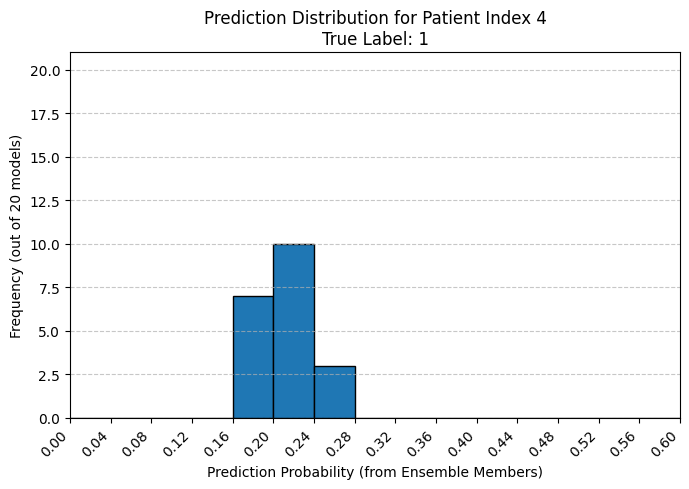

Saved plot to patient_histograms\patient_10_histogram.png


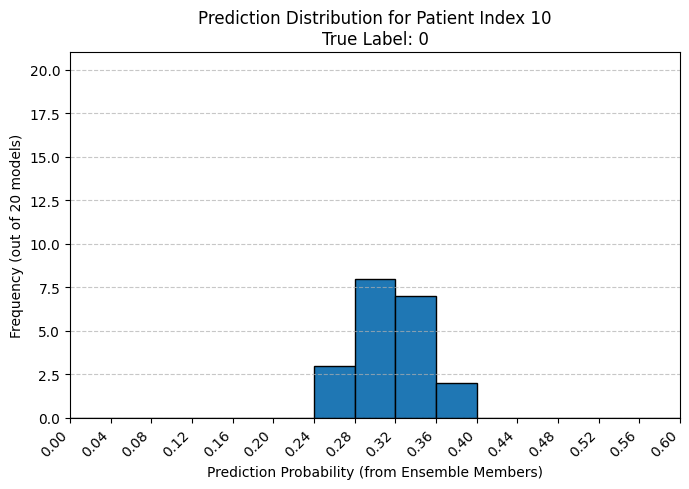

Saved plot to patient_histograms\patient_50_histogram.png


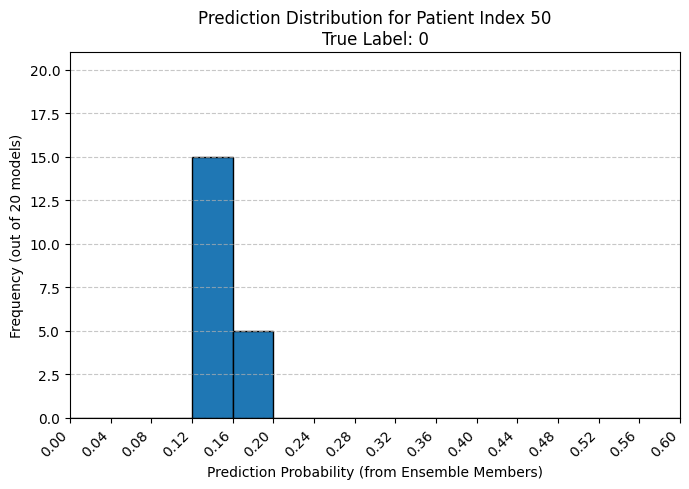

Saved plot to patient_histograms\patient_100_histogram.png


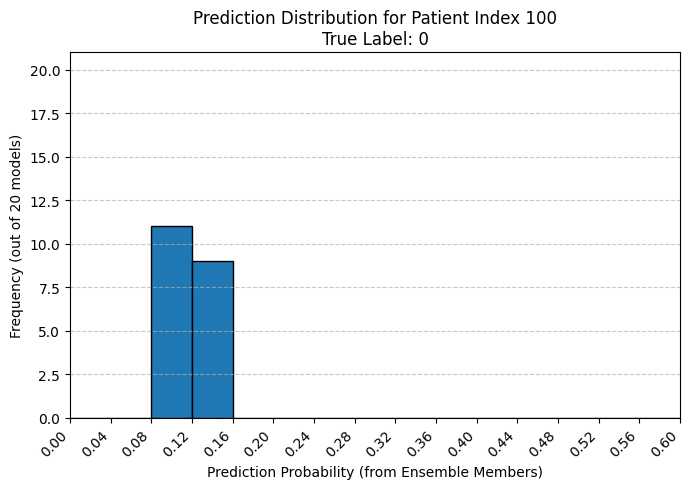


--- Uncertainty Visualization Complete ---


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os 


print("--- Visualizing Uncertainty for Selected Patients (Zoomed, 15 Bins) ---")

patient_indices_to_plot = [0, 4, 10, 50, 100] 

x_max_limit = 0.6
num_bins = 15    
bin_edges = np.linspace(0, x_max_limit, num_bins + 1) 

plot_save_dir = "patient_histograms"
os.makedirs(plot_save_dir, exist_ok=True)
print(f"Plots will be saved in: {plot_save_dir}")

if 'all_labels' not in locals():
    print("Error: `all_labels` not defined. Run previous cells.")
elif not isinstance(all_labels, np.ndarray) or all_labels.size == 0:
     print(f"Error: `all_labels` is not a populated NumPy array.")
else:
    max_index = len(all_labels) - 1
    valid_indices = [idx for idx in patient_indices_to_plot if 0 <= idx <= max_index]

    if len(valid_indices) < len(patient_indices_to_plot):
        print(f"Warning: Plotting valid indices: {valid_indices}")

    if not valid_indices:
        print("Error: No valid patient indices selected for plotting.")
    elif 'all_predictions' not in locals() or len(all_predictions) == 0 or 'ensemble_models' not in locals() or len(ensemble_models) == 0:
         print("Error: `all_predictions` or `ensemble_models` list not found or empty.")
    else:
        num_models = len(ensemble_models)
        print(f"Generating histograms based on {num_models} models.")

        for patient_idx in valid_indices:
            try:
                 patient_predictions = [all_predictions[model_idx][patient_idx] for model_idx in range(num_models)]
                 true_label = all_labels[patient_idx]

                 # Create the plot using plt interface
                 plt.figure(figsize=(7, 5))
                 plt.hist(patient_predictions, bins=bin_edges, edgecolor='black')

                 plt.title(f"Prediction Distribution for Patient Index {patient_idx}\nTrue Label: {int(true_label)}")
                 plt.xlabel("Prediction Probability (from Ensemble Members)")
                 plt.ylabel(f"Frequency (out of {num_models} models)")
                 plt.xticks(bin_edges, rotation=45, ha="right") 
                 plt.xlim(0, x_max_limit)
                 plt.ylim(0, num_models + 1)
                 plt.grid(axis='y', linestyle='--', alpha=0.7)
                 plt.tight_layout()

                 bar_figure_path = os.path.join(plot_save_dir, f'patient_{patient_idx}_histogram.png')

                 plt.savefig(bar_figure_path, bbox_inches='tight')
                 print(f"Saved plot to {bar_figure_path}")

                 plt.show()

                 plt.close()

            except Exception as e:
                 print(f"An error occurred plotting index {patient_idx}: {e}")

print("\n--- Uncertainty Visualization Complete ---")

# 12b: Scatterplot

--- Generating Mean vs. Standard Deviation Plot ---
Calculated mean and std dev for 2000 sequences.
Saved scatter plot to mean_std_dev_scatter.png


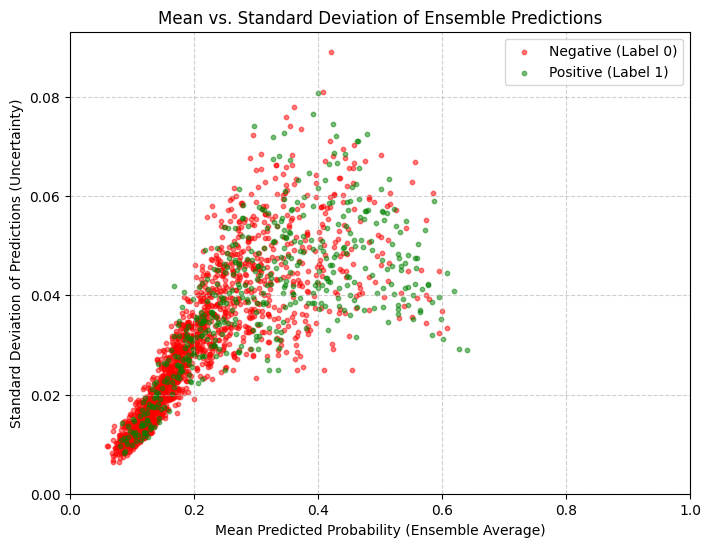


--- Scatter Plot Generation Complete ---


In [13]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Generating Mean vs. Standard Deviation Plot ---")

if 'all_predictions' not in locals() or 'all_labels' not in locals() or len(all_predictions) == 0:
    print("Error: `all_predictions` or `all_labels` not found or empty. Please run previous cells.")
else:
    try:
        predictions_array = np.array(all_predictions) 

        mean_predictions = np.mean(predictions_array, axis=0) 

        std_dev_predictions = np.std(predictions_array, axis=0) 

        print(f"Calculated mean and std dev for {len(mean_predictions)} sequences.")

        plt.figure(figsize=(8, 6))

        positive_indices = np.where(all_labels == 1)[0]
        negative_indices = np.where(all_labels == 0)[0]

        plt.scatter(mean_predictions[negative_indices], std_dev_predictions[negative_indices],
                    alpha=0.5, s=10, label='Negative (Label 0)', c='red')

        # Plot positive examples (label 1)
        plt.scatter(mean_predictions[positive_indices], std_dev_predictions[positive_indices],
                    alpha=0.5, s=10, label='Positive (Label 1)', c='green')

        plt.title('Mean vs. Standard Deviation of Ensemble Predictions')
        plt.xlabel('Mean Predicted Probability (Ensemble Average)')
        plt.ylabel('Standard Deviation of Predictions (Uncertainty)')
        plt.xlim(0, 1)
        plt.ylim(bottom=0) 
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)

        scatter_figure_path = 'mean_std_dev_scatter.png'
        plt.savefig(scatter_figure_path, bbox_inches='tight')
        print(f"Saved scatter plot to {scatter_figure_path}")

        plt.show()

    except Exception as e:
        print(f"An error occurred during scatter plot generation: {e}")

print("\n--- Scatter Plot Generation Complete ---")

# 13: Calculate Ensemble AUC - ROC


In [14]:
from sklearn.metrics import roc_auc_score


print("--- Calculating Ensemble AUC-ROC ---")

if 'all_predictions' not in locals() or 'all_labels' not in locals() or len(all_predictions) == 0:
    print("Error: `all_predictions` or `all_labels` not found or empty. Please run the previous cell first.")
else:
    try:
        ensemble_probabilities = np.mean(np.array(all_predictions), axis=0)

        if len(ensemble_probabilities) != len(all_labels):
             print(f"Error: Mismatch in length between averaged predictions ({len(ensemble_probabilities)}) and labels ({len(all_labels)}).")
        else:
            auc_score = roc_auc_score(all_labels, ensemble_probabilities)

            print(f"\nEnsemble Average Prediction calculated for {len(ensemble_probabilities)} sequences.")
            print(f"AUC-ROC Score (based on ensemble average): {auc_score:.4f}")

    except Exception as e:
        print(f"An error occurred during AUC calculation: {e}")

print("\n--- AUC Calculation Complete ---")

--- Calculating Ensemble AUC-ROC ---

Ensemble Average Prediction calculated for 2000 sequences.
AUC-ROC Score (based on ensemble average): 0.7186

--- AUC Calculation Complete ---
